In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime, timedelta
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from sklearn import svm

### Data Modeling

#### Normalization : MinMaxScaler

In [10]:
d_final = pd.read_csv('C:\workspaces\COVID19_project\src\data//d_final.csv', encoding = 'utf-8')
d_final = d_final[d_final.DEATH ==1]

In [16]:
#d_final.head()
d_final['DEATH'].value_counts()

1    32402
Name: DEATH, dtype: int64

In [17]:
# 정규화할 변수만 d_normal0에 저장
d_normal0 = d_final.loc[:, ['sex', 'intubed', 'pneumonia', 'age_grp', 'pregnancy', 'diabetes', 'copd', 'asthma', 'inmsupr',
                            'hypertension', 'other_disease', 'obesity', 'cardiovascular', 'renal_chronic', 
                            'tobacco', 'contact_other_covid', 'covid_res', 'icu']]

# y(종속변수)는 정규화 하지않고 따로 저장
d_y = d_final.loc[:, ['DEATH', 'diff_days']]

In [18]:
# 정규화
d_normal = MinMaxScaler(feature_range=(0,1)).fit_transform(d_normal0)
d_normal

array([[0. , 0.5, 1. , ..., 1. , 0. , 0.5],
       [1. , 0.5, 0. , ..., 1. , 0. , 0. ],
       [1. , 0.5, 0. , ..., 1. , 0. , 0.5],
       ...,
       [1. , 0.5, 1. , ..., 1. , 1. , 0.5],
       [0. , 0. , 0. , ..., 0. , 1. , 0.5],
       [1. , 0. , 0. , ..., 0.5, 1. , 0. ]])

#### Train, Test set 분리

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(d_normal, d_y, shuffle = True, test_size = 0.2, random_state = 1004)

In [20]:
print(X_train.shape[:],'\n', X_test.shape[:], '\n', Y_train.shape[:], '\n', Y_test.shape[:])  

(25921, 18) 
 (6481, 18) 
 (25921, 2) 
 (6481, 2)


#### Support Vector Machine

##### SVM Hyper Parameter Tuning

In [27]:
# Non-linear kernel
Y_train2 = Y_train.loc[:, "diff_days"]
svm_model = svm.SVR(kernel = 'rbf')
parameters = {'C' : [0.01, 0.1, 1, 10, 25, 50, 100],
             'gamma' : [0.01, 0.1, 1, 10, 25, 50, 100]}

- 'rbg' -> 'rbf'
- probability=True, random_state=1004 DELETED

In [38]:
grid_svm = GridSearchCV(svm_model, 
                       param_grid = parameters,
                       cv = KFold(3, random_state = 1004, shuffle=True),
                       n_jobs = 4,
                       refit=True)

### - " refit=True  " MUST BE ADDED IN ORDER TO USE .best_estimator_

In [39]:
grid_svm.fit(X_train, Y_train2)

GridSearchCV(cv=KFold(n_splits=3, random_state=1004, shuffle=True),
             estimator=SVR(), n_jobs=4,
             param_grid={'C': [0.01, 0.1, 1, 10, 25, 50, 100],
                         'gamma': [0.01, 0.1, 1, 10, 25, 50, 100]})

In [41]:
# 최적 parameter 확인
print("Best parameters (5-fold CV, gird search): " , grid_svm.best_params_)
print("Best accuracy (5-fold CV, gird search): " , grid_svm.best_score_)

Best parameters (5-fold CV, gird search):  {'C': 10, 'gamma': 0.1}
Best accuracy (5-fold CV, gird search):  -0.008692972647096934


In [42]:
cv_result_df = pd.DataFrame(grid_svm.cv_results_)
cv_result_df.sort_values(by=['rank_test_score'], inplace=True)

In [43]:
cv_result_df[['params', 'mean_test_score', 'rank_test_score']].head()

,params,mean_test_score,rank_test_score
22,"{'C': 10, 'gamma': 0.1}",-0.008693,1
29,"{'C': 25, 'gamma': 0.1}",-0.009187,2
36,"{'C': 50, 'gamma': 0.1}",-0.010613,3
42,"{'C': 100, 'gamma': 0.01}",-0.011319,4
15,"{'C': 1, 'gamma': 0.1}",-0.011413,5


In [45]:
# 최적 parameter로 xgboost 모델 생성 및 예측
#svm_best = svm_model.best_estimator_
svm_best = grid_svm.best_estimator_
Y_pred = svm_best.predict(X_test) ; Y_pred # 예측값

array([ 5.69521927,  9.56218308,  9.28077688, ..., 10.10012017,
        8.42928744, 10.89959693])

- svm_model changed to grid_svm

In [46]:
svm_best

SVR(C=10, gamma=0.1)

### Test set 성능 평가
- Test set에서의 결과 평가
- 개념설명은 https://bcho.tistory.com/1206 참고
- https://datascienceschool.net/view-notebook/731e0d2ef52c41c686ba53dcaf346f32/

In [47]:
Y_test2 = Y_test.loc[:, "diff_days"] # True 값
Y_test2 = Y_test2.reset_index(drop=True)

In [48]:
print('RMSE : %.3f' % np.sqrt(mean_squared_error(Y_test2, Y_pred)))

RMSE : 7.305


#### X축 : Y, Y축 : predicted Y 산점도 작성

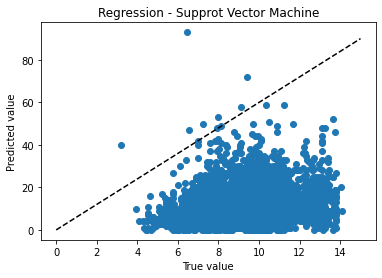

In [61]:
plt.plot(Y_pred, Y_test2, 'o')
plt.plot([0,15],[0,90], 'k--')
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.title('Regression - Supprot Vector Machine')
plt.show()

#### Y, Predicted Y export (나중에 그래프 그릴 때 쓰게)

In [55]:
d_trueY = pd.DataFrame({'Y_True':Y_test2}).reset_index(drop=True)
d_predY = pd.DataFrame({'Y_pred':Y_pred})

In [56]:
reg_svm = pd.concat([d_trueY, d_predY], axis = 1).reset_index(drop=True)
reg_svm

,Y_True,Y_pred
0,8,5.695219
1,14,9.562183
2,7,9.280777
3,15,7.146372
4,16,9.356958
...,...,...
6476,11,9.842455
6477,17,8.100032
6478,16,10.100120
6479,15,8.429287


In [57]:
reg_svm.to_csv('C://workspaces//COVID19_project//processed//reg_svm.csv', encoding='utf-8', index=False, line_terminator='\n')